# OpTaliX: Interactive 3D layout with Python

This section shows that an OpTaliX macro can be used to export all data relevant for generating interactive 3D layout plots with python. The macro looks like this:



In [1]:
PATH = r'C:\Users\herbst\OpticalDesignDocu'
with open(PATH+ "\OpTaliX\L3D.mac", 'r') as f:
    print(f.read())


! Get 3D layout incl. rays
!
print "start."
$maxfl = [si]           ! get number of surfaces
!$sur = 2
$wl = 1
$fi = 1

out fil C:\Work\OpTaliX\Test\layout_3D.txt   ! redirect output to file
print "C sur vgx vgy vgz r x y n"

do $sur = 0,$maxfl    ! loop through all surfaces
   ! get vertex data
   $vgx = [xsc s$sur]
   $vgy = [ysc s$sur]
   $vgz = [zsc s$sur]
   $thi = [thi s$sur]
      
   ! get aperture data
   $rmax = [sd s$sur]   ! Maximum semi-diameter on surface sk.
   
   ! get glass material, refractive index
   $n = [ind s$sur w$wl]

   print 'format I3,F14.9, F14.9, F14.9, F14.9, F14.9, G13.5' $sur $vgx $vgy $vgz $rmax $n $thi
   
enddo

! get sag data, save in extra file
! SAG sk x_height y_height 

out fil C:\Work\OpTaliX\Test\sag.txt

do $sur = 1,$maxfl
   if ($sur > 0) then
      $rmax = [sd s$sur] 
      $dr = $rmax/20
   
      do $r = -$rmax,$rmax, $dr   ! loop through radial coordinate
         $xh = $r
         $sagx = [SAG s$sur $xh 0]
         $sagy = [SAG s$sur 0

After this macro has been run within OpTaliX with the command "run L3D.mac" some files exists within the provided folder. These files are read by the python script below:

In [2]:
import numpy as np
import matplotlib.pylab as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.colors import n_colors
import time 
import math

import warnings
warnings.filterwarnings('ignore')

t0 = time.perf_counter()

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

# ===================================
## settings:
    
draw_sagittal = 0          # draw sagittal rays

Opacity = 0.15             # opacity of drawn "glass" surfaces
show_labels = 0            # show labels: very slow in pyvista
plot_edge = 1              # plot minimal edges of lenses, corresponds to : EDG si..sj lin
edge_type = "lin"          # options: "lin", "rec", 
draw_rays_prior1 = 1       # draw rays prior to surface 1
thi_draw = 20              # draw rays prior to surface 1 for this length
draw_paraxial_data = 1

create_gif = 0             # generate a gif (of the rotating layout)
use_pythreejs = 1

# these are the files written by the macro "L3D.mac":
filename_py = r'C:\Work\OpTaliX\Test\RAY_FAN_PY_ALL.txt'
filename_px = r'C:\Work\OpTaliX\Test\RAY_FAN_PX_ALL.txt'
filename_layout3D = r'C:\Work\OpTaliX\Test\LAYOUT_3D.txt'
filename_sag = r'C:\Work\OpTaliX\Test\SAG.txt'
# ==================================


nsurfaces = int(np.loadtxt(filename_py, comments = 'C',max_rows=1)[0])
nwavelengths = int(np.loadtxt(filename_py, comments = 'C',max_rows=1)[1])
nfields = int(np.loadtxt(filename_py, comments = 'C',max_rows=1)[2])
stopsurface = int(np.loadtxt(filename_py, comments = 'C',max_rows=1)[3])

if nwavelengths > 1:
    wavelengths = np.loadtxt(filename_py, comments = 'C',skiprows = 2, max_rows=nwavelengths)[:,1]
else:
    wavelengths = np.loadtxt(filename_py, comments = 'C',skiprows = 2, max_rows=nwavelengths)[1]
    
fields = np.loadtxt(filename_py, comments = 'C',skiprows = 2+nwavelengths, max_rows=nfields)

rayfandata_py = np.loadtxt(filename_py, comments = 'C', skiprows = nwavelengths+2+nfields)


rayfandata_px = np.loadtxt(filename_px, comments = 'C', skiprows = nwavelengths+2+nfields)

n_fields = len(fields)
Lim = 0.02    # mm
#nwavelengths = 3


rayfandata_px_L= []
rayfandata_py_L = []
rayfandata_PY0_L = []

for s in range(0, nsurfaces):
    rayfandata_px_LL = []
    rayfandata_py_LL = []
    rayfandata_px00 = rayfandata_px[rayfandata_px[:,0]==s+1]
    rayfandata_py00 = rayfandata_py[rayfandata_py[:,0]==s+1]                 # select data by wavelength
    for w in range(0, nwavelengths):
        #print("w = ", w)
        rayfandata_px_LLL = []
        rayfandata_py_LLL = []
        rayfandata_px0 = rayfandata_px00[rayfandata_px00[:,1]==w+1]
        rayfandata_py0 = rayfandata_py00[rayfandata_py00[:,1]==w+1]                 # select data by wavelength
        
    
        
        for i in range(0, n_fields):
            rayfandata_px_LLL.append(rayfandata_px0[rayfandata_px0[:,2]==i+1])
            rayfandata_py_LLL.append(rayfandata_py0[rayfandata_py0[:,2]==i+1] )           # select data by field
            
        rayfandata_px_LL.append(np.array(rayfandata_px_LLL))
        rayfandata_py_LL.append(np.array(rayfandata_py_LLL))
        
    rayfandata_px_L.append(np.array(rayfandata_px_LL))
    rayfandata_py_L.append(np.array(rayfandata_py_LL))
 
                

#filename_layout3D = r'C:\Work\OpTaliX\Test\LAYOUT_3D.txt'
layout_3D_0 = np.loadtxt(filename_layout3D, comments = 'C')
layout_3D = layout_3D_0[1:]
thi = layout_3D_0[:,-1]

# calculate starting points of fields
if draw_rays_prior1:
    import pyvista as pv
    
    xypos0 = np.tan(fields[:,1:]*math.pi/180)*thi[0]
    
    xyzpos0 = np.stack((xypos0[:,0], xypos0[:,1], np.ones(len(xypos0))*thi[0])).T
    # create vectors:
    s = 0
    mesh_prior1_L = []
    mesh_prior1x_L = []
    for w in range(0, nwavelengths):
        for i in range(0, n_fields):
            
            for p in range(0, len(rayfandata_py_L[0][w][i])): 
                pos1 = np.stack((rayfandata_py_L[s][w][i][p,4],rayfandata_py_L[s][w][i][p,5] , rayfandata_py_L[s][w][i][p,6]+ layout_3D[s,3])).T 
                vec = pos1-xyzpos0[i]
                vec /= np.linalg.norm(vec)
                vec *= thi_draw 
                pos0 = pos1 + vec
                if p == 0:
                    mesh_prior1 = pv.lines_from_points(np.array([pos0,pos1]))
                else:
                    mesh_prior1 += pv.lines_from_points(np.array([pos0,pos1]))
                    
            if draw_sagittal:
                for p in range(0, len(rayfandata_px_L[0][w][i])): 
                    pos1x = np.stack((rayfandata_px_L[s][w][i][p,4],rayfandata_px_L[s][w][i][p,5] , rayfandata_px_L[s][w][i][p,6]+ layout_3D[s,3])).T 
                    vecx = pos1x-xyzpos0[i]
                    vecx /= np.linalg.norm(vecx)
                    vecx *= thi_draw 
                    pos0x = pos1x + vecx
                    if p == 0:
                        mesh_prior1x = pv.lines_from_points(np.array([pos0x,pos1x]))
                    else:
                        mesh_prior1x += pv.lines_from_points(np.array([pos0x,pos1x]))
                        
                    
            mesh_prior1_L.append(mesh_prior1)
            if draw_sagittal:
                mesh_prior1x_L.append(mesh_prior1x)
                
#filename_sag = r'C:\Work\OpTaliX\Test\SAG.txt'
sag = np.loadtxt(filename_sag, comments = 'C')

p = np.linspace(0, 2*np.pi, 50) 

import pyvista as pv
sag_data_L = []
mesh_L = []
mesh_prof_L = []
mesh_prof_Ly = []
mesh_circ_L = []
Z0 = 0

def circle_points(R=1):
    p = np.linspace(0, 2*np.pi, 50)
    x, y = R*np.cos(p), R*np.sin(p)
    #F = x**2 + y**2
    return x, y

sag_data_stop = sag[sag[:,0]==stopsurface]
r_stop = np.max(sag_data_stop[:,1])

n_mat = layout_3D[:,5]

r_max_L = []
points_circ_L = []
points_circ_L2 = []
surf_L = []
points_label_L = []
r_L = []
for s in range(0, nsurfaces):
    
    sag_data = sag[sag[:,0]==s+1]
    sag_data_L.append(sag_data)
    r = sag_data[:,1]
    r_L.append(r)
    #if n_mat[s-1] > 1:
    #   r2 = r_L[s-1]
        
    r_max_L.append(np.max(r))
    R, P = np.meshgrid(r, p)
    # Express the mesh in the cartesian system.
    X, Y = R*np.cos(P), R*np.sin(P)
    
    x_c, y_c= circle_points(R = np.max(r))
    #if n_mat[s-1] > 1:
    #    x_c, y_c= circle_points(R = np.max(r2))
    sa = sag_data[:,2:]
    Z = np.repeat(sa[np.newaxis, :, :], len(p), axis=0) + layout_3D[s,3]
    points = np.stack((X.flatten(), Y.flatten(), Z[:,:,0].flatten())).T
    mesh = pv.PolyData(points).delaunay_2d()
    mesh_prof_x = pv.lines_from_points(np.stack((r, np.zeros(len(r)), sa[:,0]+ layout_3D[s,3])).T)
    mesh_prof_y = pv.lines_from_points(np.stack((np.zeros(len(r)), r, sa[:,1]+ layout_3D[s,3])).T)
    points_circ = np.stack((x_c, y_c, layout_3D[s,3]*np.ones(len(y_c))+ np.min(sa)+np.max(sa) )).T
    mesh_circ = pv.lines_from_points(points_circ)
    mesh_L.append(mesh)
    mesh_prof_L.append(mesh_prof_x)
    mesh_prof_Ly.append(mesh_prof_y)
    mesh_circ_L.append(mesh_circ)
    points_circ_L.append(points_circ)
    points_circ_L2.append(points_circ)
    
    points_label_L.append(points_circ_L[s][int(len(points_circ_L[s])/2)])

atest = (np.stack((np.zeros(len(points_circ_L[s])), np.zeros(len(points_circ_L[s])), np.ones(len(points_circ_L[s])))).T)

points_element_L = []
for s in range(0, nsurfaces):    
    if n_mat[s] > 1:
        if edge_type == "lin":
            points_element = np.vstack((points_circ_L[s], points_circ_L[s+1] ))
            
            pointsc = pv.PolyData(points_element)
            surf = pointsc.delaunay_2d()#.reconstruct_surface()
            surf_L.append(surf)
            
        elif edge_type == "rec":
            sa = sag_data_L[s][:,2:]
            sa2 = sag_data_L[s+1][:,2:]
            
            M1 = np.min(sa)+np.max(sa)
            M2 = np.min(sa2)+np.max(sa2)
            #print(M1-M2)
            
            mesh = pv.lines_from_points(points_circ_L[s])
            surf = mesh.extrude((0, 0, M2-M1+thi[s+1] ), capping=True)
            mesh_circ_L[s] += pv.lines_from_points(points_circ_L[s]+atest*(M2-M1+thi[s+1]))
            surf_L.append(surf)
    #Z0+= layout_3D[i,3]


#for s in range(0, nsurfaces):
#    if n_mat[s]>1:
    
s =1
sag_data = sag[sag[:,0]==s+1]
sag_data2 = sag[sag[:,0]==s]
sag_data_L.append(sag_data)
r = sag_data2[:,1]
sa = sag_data[:,2:]
x_c, y_c= circle_points(R = np.max(r))    
points_circ = np.stack((x_c, y_c, layout_3D[s,3]*np.ones(len(y_c))+ np.min(sa)+np.max(sa) )).T
points_circ_Lt = points_circ
points_element = np.vstack((points_circ_L[s], points_circ_Lt))
pointsc = pv.PolyData(points_element)
surf = pointsc.delaunay_2d()


mesh_ray_Ly = []
points_Ly = []
mesh_p_L = []

mesh_ray_Lx = []
mesh_p_L_x = []

for w in range(0, nwavelengths):
    for i in range(0, n_fields):
        
        for p in range(0, len(rayfandata_py_L[0][w][i])): 
            ray = []
            ray_x = []
            for s in range(0, nsurfaces):
                r = np.stack((rayfandata_py_L[s][w][i][p,4],rayfandata_py_L[s][w][i][p,5] , rayfandata_py_L[s][w][i][p,6]+ layout_3D[s,3])).T
                ray.append(r)
                
                
            ray = np.array(ray)
            mesh_ray = pv.lines_from_points(ray)
            mesh_p0 = pv.PolyData(ray)
            

            
            if p == 0:
                mesh_ray_g = mesh_ray
                mesh_p = mesh_p0
                

            else:
                mesh_ray_g += mesh_ray
                mesh_p += mesh_p0
                

                
        for p in range(0, len(rayfandata_px_L[0][w][i])): 
            ray_x = []
            for s in range(0, nsurfaces):
                r_x = np.stack((rayfandata_px_L[s][w][i][p,4],rayfandata_px_L[s][w][i][p,5] , rayfandata_px_L[s][w][i][p,6]+ layout_3D[s,3])).T
                ray_x.append(r_x)
            ray_x = np.array(ray_x)
            mesh_ray_x = pv.lines_from_points(ray_x)
            mesh_p0_x = pv.PolyData(ray_x)
            
            if p == 0:
                mesh_ray_g_x = mesh_ray_x
                mesh_p_x = mesh_p0_x
            else:
                mesh_ray_g_x += mesh_ray_x
                mesh_p_x += mesh_p0_x
                
        mesh_ray_Ly.append(mesh_ray_g)
        mesh_p_L.append(mesh_p)
        
        mesh_ray_Lx.append(mesh_ray_g_x)
        mesh_p_L_x.append(mesh_p_x)



# get refractive index / material
# fill volume between surfaces with glass.
    
   
from pyvistaqt import BackgroundPlotter

if 'pl' in globals():
    pl.close()
    pl.clear()
if 1:
    if create_gif:
        pl = pv.Plotter(notebook=False, off_screen=True)
    else:
        #pl = BackgroundPlotter(shape=(1, 1))
        pl = pv.Plotter()
        #pl = pv.PlotterITK()
    
    #pl = pv.Plotter(shape=(1, 1))
    pl.set_background("white")  # "gray", top="black"
    #plotter.subplot(0, 0)
    Colorline = "green"
    pv.create_axes_orientation_box(line_width=1, text_scale=0.366667, edge_color=Colorline, x_color=None, y_color=None, z_color=None, xlabel='X', ylabel='Y', zlabel='Z', x_face_color='red', y_face_color='green', z_face_color='blue', color_box=False, label_color=None, labels_off=False, opacity=0.5)
    pl.add_axes(color = Colorline)
    pl.add_bounding_box(color=Colorline, corner_factor=0.5, line_width=None, opacity=1.0, render_lines_as_tubes=False, lighting=None, reset_camera=None, outline=True, culling='front')
    pl.show_bounds(font_size = 15, color=Colorline)
#plotter.show()




poly = pv.PolyData(np.array(points_label_L))
poly["My Labels"] = [f"{i}" for i in range(poly.n_points)]

for s in range(0, nsurfaces):
    if n_mat[s]>1: #or n_mat[s-1]>1:
        color_aper = 'red'
        color_aper = 'black'
    else:
        color_aper = 'black'
        
    if s == stopsurface-1:
        color_aper = 'blue'
        Linewidth = 2
    else:
        Linewidth = 1
    
    if s == nsurfaces-1:
        colorS = "white"
        ac1 = pl.add_mesh(mesh_L[s],show_edges=False, opacity = 0, color = colorS)
    else:
        if n_mat[s]>1:
            colorS = "cyan"
        else:
            colorS = "white"
        ac1 = pl.add_mesh(mesh_L[s],show_edges=False, opacity = Opacity, color = colorS)
    ac2 = pl.add_mesh(mesh_prof_L[s],show_edges= True, opacity = 1, color = 'black')
    ac3 = pl.add_mesh(mesh_prof_Ly[s],show_edges= True, opacity = 1, color = 'black')
    ac4 = pl.add_mesh(mesh_circ_L[s],show_edges= True, opacity = 1, color = color_aper, line_width = Linewidth)
    
    if show_labels:
        pl.add_point_labels(poly, "My Labels", point_size=20, font_size=36)


cm_subsection = np.linspace(0.0, 1.0, n_fields) 
from matplotlib import cm
colors = ['blue', 'green', 'red', 'magenta']

for i in range(0, len(mesh_ray_Ly)):    
    pl.add_mesh(mesh_ray_Ly[i],show_edges= True, opacity = 1, color = colors[i])
    pl.add_mesh(mesh_p_L[i],show_edges= True, opacity = 1, color = colors[i])
    
    if draw_rays_prior1:
       pl.add_mesh(mesh_prior1_L[i],show_edges= True, opacity = 1, color = colors[i])
        
if draw_sagittal:
    for i in range(0, len(mesh_ray_Lx)):       
        pl.add_mesh(mesh_ray_Lx[i],show_edges= True, opacity = 1, color = colors[i])
        pl.add_mesh(mesh_p_L_x[i],show_edges= True, opacity = 1, color = colors[i])
        
        if draw_rays_prior1:
            pl.add_mesh(mesh_prior1x_L[i],show_edges= True, opacity = 1, color = colors[i])    

if plot_edge:
    for i in range(0, len(surf_L)):
        if use_pythreejs:

            pl.add_mesh(surf_L[i], color = 'cyan', opacity = Opacity)  #  roughness=0, metallic=0.5
        else:
            pl.add_mesh(surf_L[i], color = 'cyan', opacity = Opacity)
        
    #pl.add_mesh(points_circ_Lt, color = 'orange', opacity = Opacity)
    #pl.add_mesh(surf, color = 'red', opacity = 1)

# cpos = [
#     (21.9930, 21.1810, -30.3780),
#     (-1.1640, -1.3098, -0.1061),
#     (0.8498, -0.2515, 0.4631),
# ]
pl.camera_position = 'zy'   
pl.enable_parallel_projection()
#pl.enable_image_style()
#pl.view_zy()
#if not create_gif:
#    pl.show(jupyter_backend='pythreejs')  # jupyter_backend='pythreejs'

# do some animation 
rot = np.linspace(1, 360, num = 36)
# Open a gif
if create_gif:
    pl.open_gif("rotate3D.gif")
    for r in range(0, len(rot)):
        pl.camera.azimuth = rot[r]
        print("frame = ", r)
        pl.write_frame()
    pl.close()
    
    


      
    
print("Elapsed time: ", np.round(time.perf_counter()-t0, decimals = 4), " s")

ModuleNotFoundError: No module named 'pyvista'

There are different ways to generate a plot. Either from a .py script where you can use pyvista's pv.Plotter or BackgroundPlotter to obtain an interactive plot within an extra window. These plots are not interactive within this jupyter notebook environement, however. The plots are inserted as here as simple images instead (first with lin. edge):

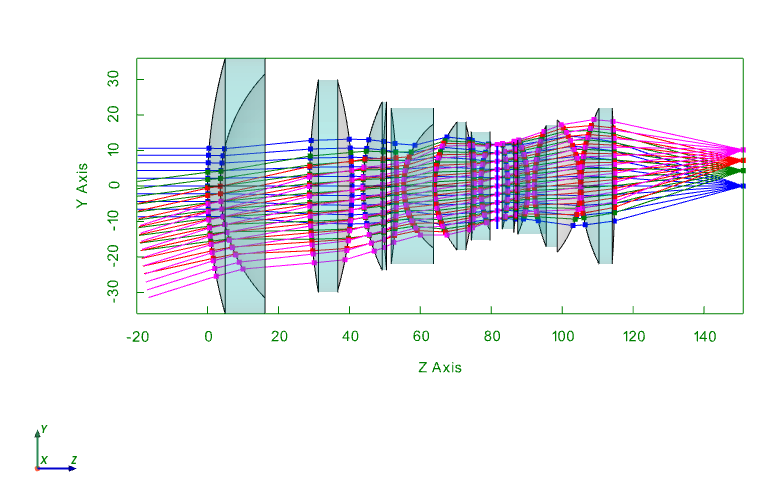

In [74]:
PATH = r'C:\Users\herbst\OpticalDesignDocu'
from IPython.display import Image
Image(filename = PATH + "\OpTaliX\OpTaliX_3D_rect.png", width=1000, height=800)

And with rect edge:

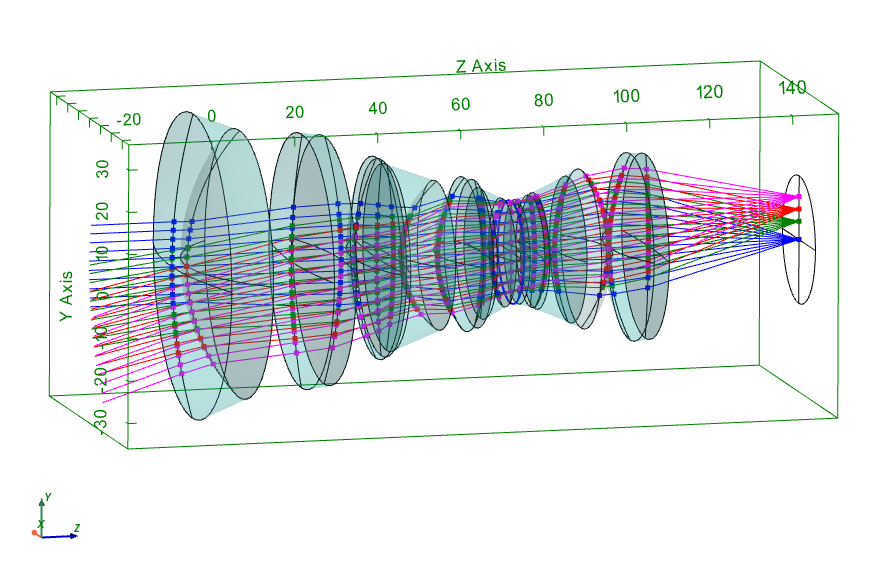

In [75]:
PATH = r'C:\Users\herbst\OpticalDesignDocu'
from IPython.display import Image
Image(filename = PATH + "\OpTaliX\OpTaliX_3D_lint.png", width=1000, height=800)

Within jupyter the backend "pythreejs" can be used:

In [76]:
if use_pythreejs:
    pl.show(jupyter_backend='pythreejs')
else:
    pl.show()


Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(color='#fefefe', inten…

A gif can be generated as well and is inserted below:

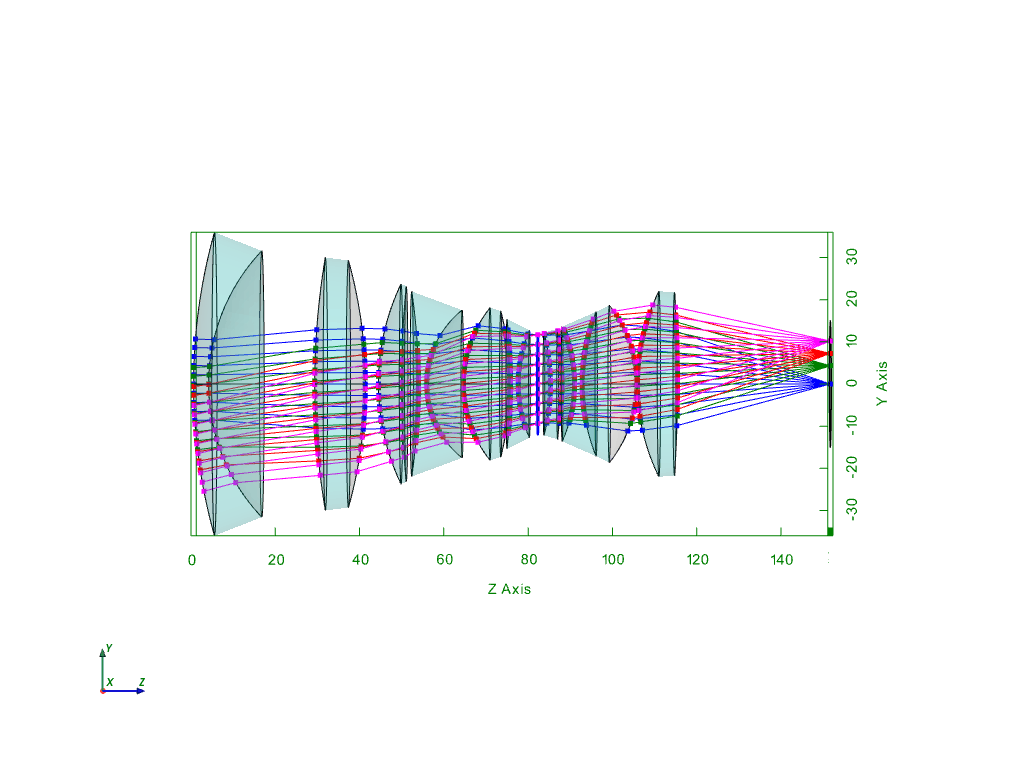

In [77]:
gif_path = r'C:\Users\herbst\.spyder-py3\Python Scripts\Optalix\rotate3D.gif'
from IPython.display import Image
#display(Image(data=open(gif_path,'rb').read(), format='png'))

with open(gif_path,'rb') as f:
    display(Image(data=f.read(), format='png'))

#import ipywidgets as widgets
#display(widgets.HTML(f'<img src="{gif_path}" width="750" align="center">'))
